# Week 2：Analysis of Uber Platform and Competing Price Factors

Online car-hailing platforms do not have constant prices like public transportation such as subways/buses. Generally speaking, the price of an online car-hailing trip is related to factors such as mileage, time, demand, weather conditions, and local transportation convenience.

Next, we have a relatively large data set, which lasts for one week, including travel data from Uber and Lyft platforms and weather data during the same period. Please try to analyze according to the data content and actual map location information:

    Relationship between trip length and price
    Relationship between trip price and climate
    Relationship between trip type and price

Also try to summarize the characteristics of these data in time domain and space domain. For example, what is the common direction of migration in the morning? What is the common direction of migration in the evening? Is there a specific difference in the characteristics of a weekday itinerary and a weekend itinerary? Wait, wait, etc., summarize a report, and try to give statistics and solutions for optimizing the operation of drivers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.interpolate import interp1d

N_EST = 10 #set to 100 or more for improved accuracy on models

In [2]:
cab_rides_file_path = "data/cab_rides.csv"
cab_rides_df = pd.read_csv(cab_rides_file_path)
display(cab_rides_df.head())

weather_file_path = "data/weather.csv"
weather_df = pd.read_csv(weather_file_path)
weather_df['rain'] = weather_df['rain'].fillna(0)
display(weather_df.head())

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


### Part 1: Relationship between trip length and price

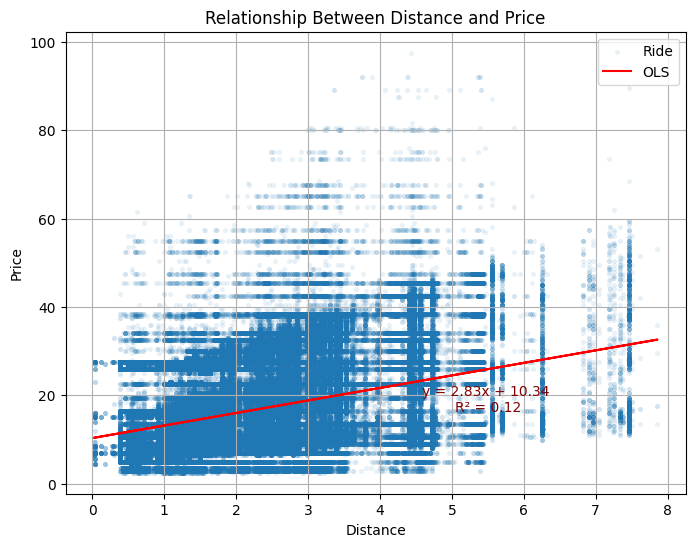

In [3]:
model = LinearRegression()
crdf = cab_rides_df.dropna(subset=['price'])
X = crdf.distance.to_numpy().reshape(-1,1)
y = crdf.price.to_numpy()
model.fit(X, y)
y_pred = model.predict(X)
reg_func = f"y = {model.coef_[0]:.2f}x + {model.intercept_:.2f} \nR² = {model.score(X, y):.2f}"

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X.flatten(), y=y, label='Ride', alpha=0.1, s=10, edgecolor=None)
plt.plot(X, y_pred, color='red', label='OLS')
plt.text(5.5, 19, reg_func, fontsize=10, color="maroon", ha='center', va='center')
plt.xlabel('Distance')
plt.ylabel('Price')
plt.title('Relationship Between Distance and Price')
plt.legend()
plt.grid(True)
plt.show()

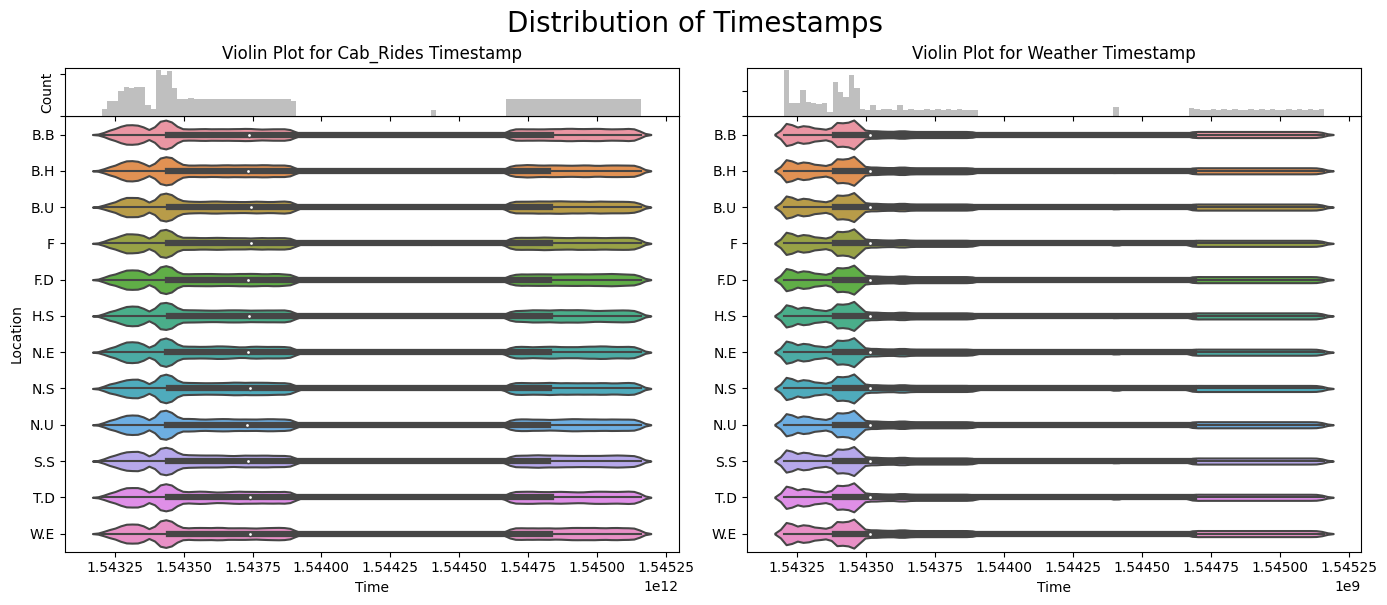

In [4]:
cab_rides_df["loc_s"] = cab_rides_df["source"].apply(lambda loc: '.'.join([c for c in loc if c.isupper()]))
cab_rides_df["loc_d"] = cab_rides_df["destination"].apply(lambda loc: '.'.join([c for c in loc if c.isupper()]))
weather_df["loc"] = weather_df["location"].apply(lambda loc: '.'.join([c for c in loc if c.isupper()]))

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 9], hspace=0)

# Violin plots
ax1 = fig.add_subplot(gs[1, 0])
sns.violinplot(ax=ax1, x='time_stamp', y='loc_s', data=cab_rides_df, bw=0.025, order=np.sort(cab_rides_df['loc_s'].unique()))
ax1.set_title('Violin Plot for Cab_Rides Timestamp',y=1.1125)
ax1.set_xlabel('Time')
ax1.set_ylabel('Location')
ax1.tick_params(axis='x')

ax2 = fig.add_subplot(gs[1, 1])
sns.violinplot(ax=ax2, x='time_stamp', y='loc', data=weather_df, bw=0.025, order=np.sort(weather_df['loc'].unique()))
ax2.set_title('Violin Plot for Weather Timestamp',y=1.1125)
ax2.set_xlabel('Time')
ax2.set_ylabel('')
ax2.tick_params(axis='x')

# Histograms
ax_hist1 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax_hist1.hist(cab_rides_df['time_stamp'], bins=100, alpha=0.5, color='gray')
ax_hist1.set_title('')
ax_hist1.tick_params(axis='y', labelleft=False)
ax_hist1.tick_params(axis='x', labelbottom=False)
ax_hist1.set_ylabel('Count')

ax_hist2 = fig.add_subplot(gs[0, 1], sharex=ax2)
ax_hist2.hist(weather_df['time_stamp'], bins=100, alpha=0.5, color='gray')
ax_hist2.set_title('')
ax_hist2.tick_params(axis='y', labelleft=False)
ax_hist2.tick_params(axis='x', labelbottom=False)
ax_hist2.set_ylabel('')

plt.suptitle('Distribution of Timestamps', y=1, fontsize=20)
plt.tight_layout()
plt.show()

### Part 2: Relationship between trip price and climate

In [5]:
weather_dict = {loc: df.sort_values('time_stamp').drop(['location', 'loc'], axis=1) for loc, df in weather_df.groupby('location')}

def interpolate_row(df, ts):
    df['time_diff'] = df['time_stamp'] - ts
    df_before = df[df['time_diff'] <= 0]
    df_after = df[df['time_diff'] >= 0]
    try:
        row_before = df_before.iloc[-1]
        row_after = df_after.iloc[0]
        diff = row_after['time_stamp'] - row_before['time_stamp']
        ratio = (ts - row_before['time_stamp']) / diff
        interpolated_row = row_before + ratio * (row_after - row_before)
    except:
        interpolated_row = df_before.iloc[-1]
    return interpolated_row.round(4)

def row_from_loc_time(loc, ts):
    df_loc = weather_dict[loc]
    return interpolate_row(df_loc, ts/1000)

def gen_full_row(row):
    src_data = row_from_loc_time(row['source'], row['time_stamp'])
    dst_data = row_from_loc_time(row['destination'], row['time_stamp'])
    
    src_data = src_data[['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']]
    dst_data = dst_data[['temp', 'clouds', 'pressure', 'rain', 'humidity', 'wind']]
    
    cols = row.index.tolist() + [f'{col}_s' for col in src_data.index] + [f'{col}_d' for col in dst_data.index]
    combined_data = pd.concat([row, src_data, dst_data], axis=0).values
    
    return pd.Series(combined_data, index=cols)

In [6]:
out_path = 'data/combined.csv'
tqdm.pandas()

if not os.path.isfile(out_path):
    df_combined = cab_rides_df.progress_apply(gen_full_row, axis=1)
    df_combined.to_csv(out_path,index=False)
else:
    print("Combined File Ready.")
    df_combined = pd.read_csv(out_path)

display(df_combined.head())

Combined File Ready.


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,pressure_s,rain_s,humidity_s,wind_s,temp_d,clouds_d,pressure_d,rain_d,humidity_d,wind_d
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,1022.2971,0.0000,0.7550,7.7941,38.6334,0.2622,1022.4250,0.0000,0.7550,7.9020
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,1003.8230,0.4364,0.9000,13.5454,44.2201,1.0000,1003.8288,0.4322,0.9050,13.5103
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,992.2464,0.0000,0.7513,9.2114,38.7170,0.0486,992.0737,0.0000,0.7321,7.4779
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,1013.7119,0.0000,0.7001,5.2491,35.0582,0.0000,1013.7119,0.0000,0.7001,5.2191
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,998.4851,0.0000,0.7043,10.1644,37.5803,0.5347,998.4894,0.0000,0.7143,10.1359


Creating Random Forest Model...
Random Forest Model Created!
Creating Linear Regression Model...
Linear Regression Model Created!


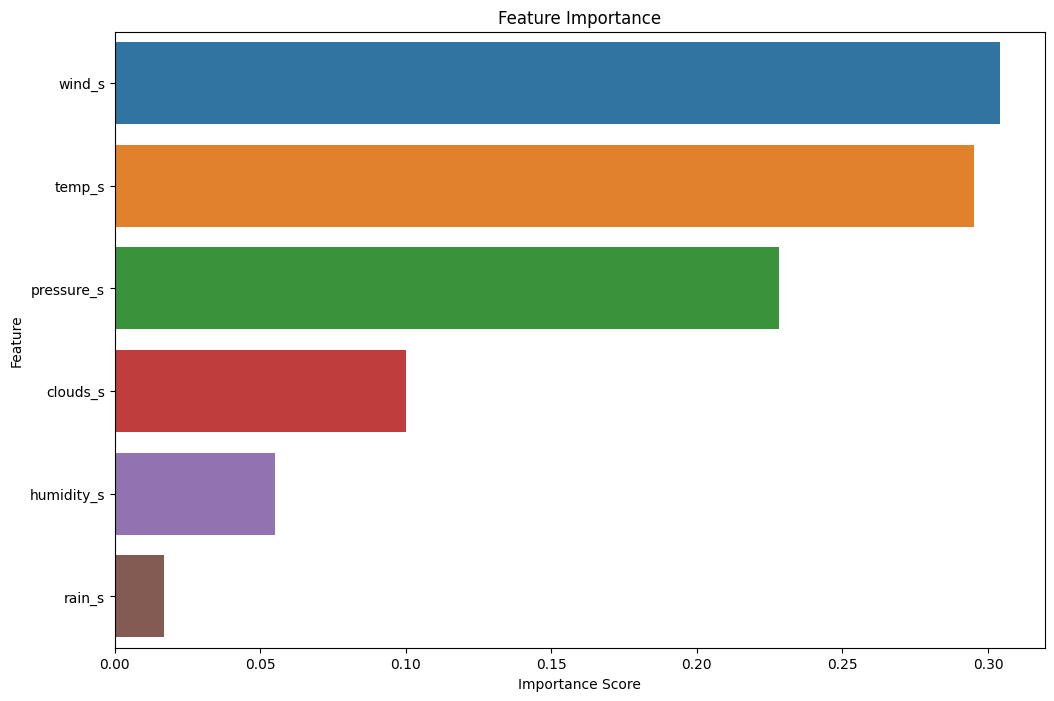

In [7]:
weather_cols = ['temp_s', 'clouds_s', 'pressure_s', 'rain_s', 'humidity_s', 'wind_s']
crdf = df_combined.dropna(subset=['price'] + weather_cols)

X = crdf[weather_cols].to_numpy()
y = crdf.price.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Creating Random Forest Model...")
rf_model = RandomForestRegressor(n_estimators=N_EST, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Model Created!")

print("Creating Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression Model Created!")

feature_importances = rf_model.feature_importances_
features = weather_cols

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

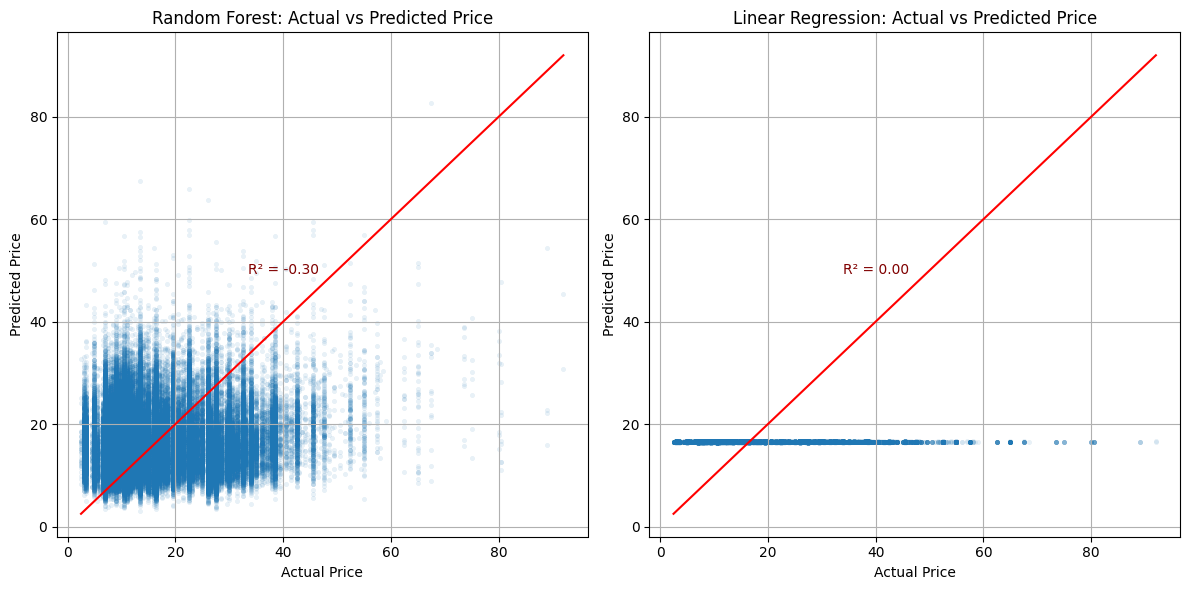

In [8]:
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_rf, alpha=0.1, s=10, edgecolor=None)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
axes[0].text(40, 50, f"R² = {r2_score(y_test, rf_model.predict(X_test)):.2f}", fontsize=10, color="maroon", ha='center', va='center')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Random Forest: Actual vs Predicted Price')
axes[0].grid(True)

sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_lr, alpha=0.1, s=10, edgecolor=None)
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
axes[1].text(40, 50, f"R² = {r2_score(y_test, lr_model.predict(X_test)):.2f}", fontsize=10, color="maroon", ha='center', va='center')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('Linear Regression: Actual vs Predicted Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Part 3: Relationship between trip type and price

In [9]:
df_types = pd.get_dummies(df_combined['name'], prefix='type')
df_types = pd.concat([df_combined, df_types], axis=1)
df_types.columns = ["_".join(col.split()) for col in df_types.columns]
display(df_types.head())

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,type_Lux_Black,type_Lux_Black_XL,type_Lyft,type_Lyft_XL,type_Shared,type_Taxi,type_UberPool,type_UberX,type_UberXL,type_WAV
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0,0,0,0,1,0,0,0,0,0
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0,0,0,0,0,0,0,0,0,0
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0,0,1,0,0,0,0,0,0,0
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0,1,0,0,0,0,0,0,0,0
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,0,0,0,1,0,0,0,0,0,0


Creating Random Forest Model...
Random Forest Model Created!
Creating Linear Regression Model...
Linear Regression Model Created!


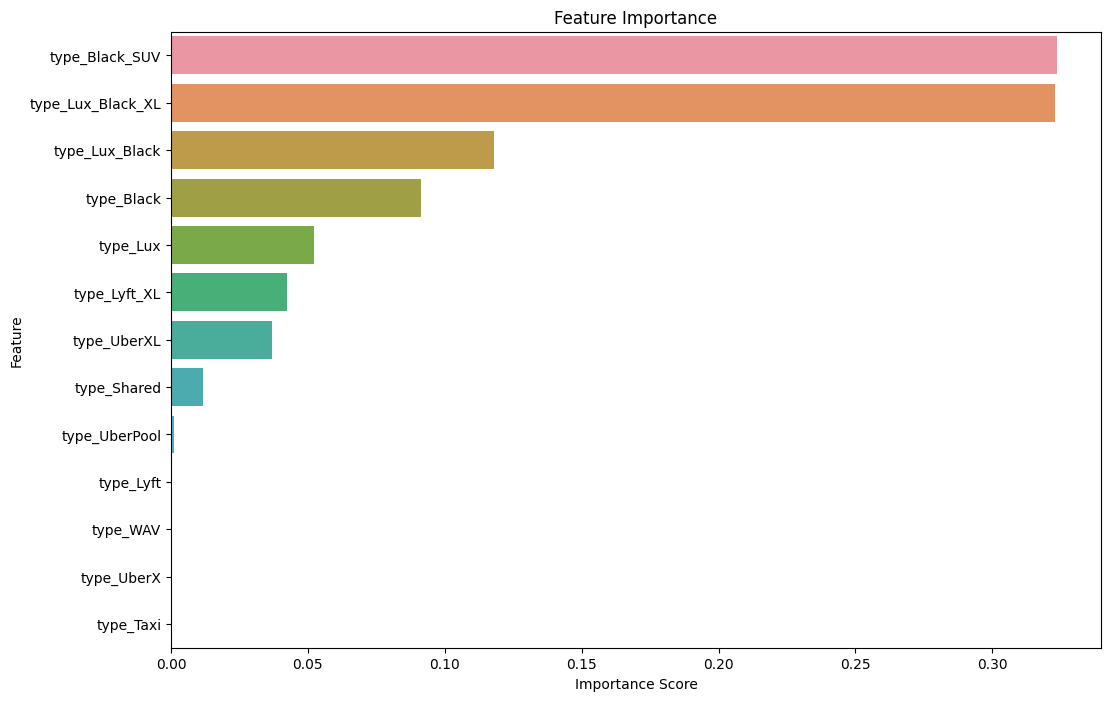

In [10]:
type_cols = df_types.columns[-13:].tolist()
crdf = df_types.dropna(subset=['price'] + type_cols)

X = crdf[type_cols].to_numpy()
y = crdf.price.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Creating Random Forest Model...")
rf_model = RandomForestRegressor(n_estimators=N_EST, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Model Created!")

print("Creating Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression Model Created!")

feature_importances = rf_model.feature_importances_
features = type_cols

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

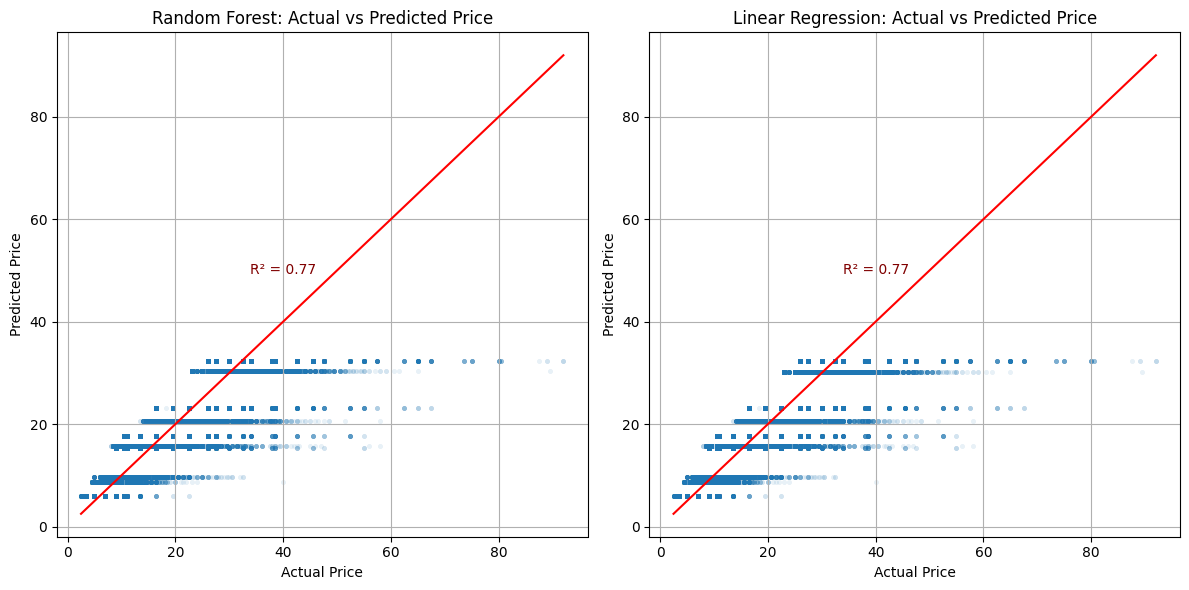

In [11]:
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_rf, alpha=0.1, s=10, edgecolor=None)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
axes[0].text(40, 50, f"R² = {r2_score(y_test, rf_model.predict(X_test)):.2f}", fontsize=10, color="maroon", ha='center', va='center')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Random Forest: Actual vs Predicted Price')
axes[0].grid(True)

sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_lr, alpha=0.1, s=10, edgecolor=None)
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
axes[1].text(40, 50, f"R² = {r2_score(y_test, lr_model.predict(X_test)):.2f}", fontsize=10, color="maroon", ha='center', va='center')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('Linear Regression: Actual vs Predicted Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Part 4: Relationship between Price and [Distance, Weather, Trip_Type]

Creating Random Forest Model...
Random Forest Model Created!
Creating Linear Regression Model...
Linear Regression Model Created!


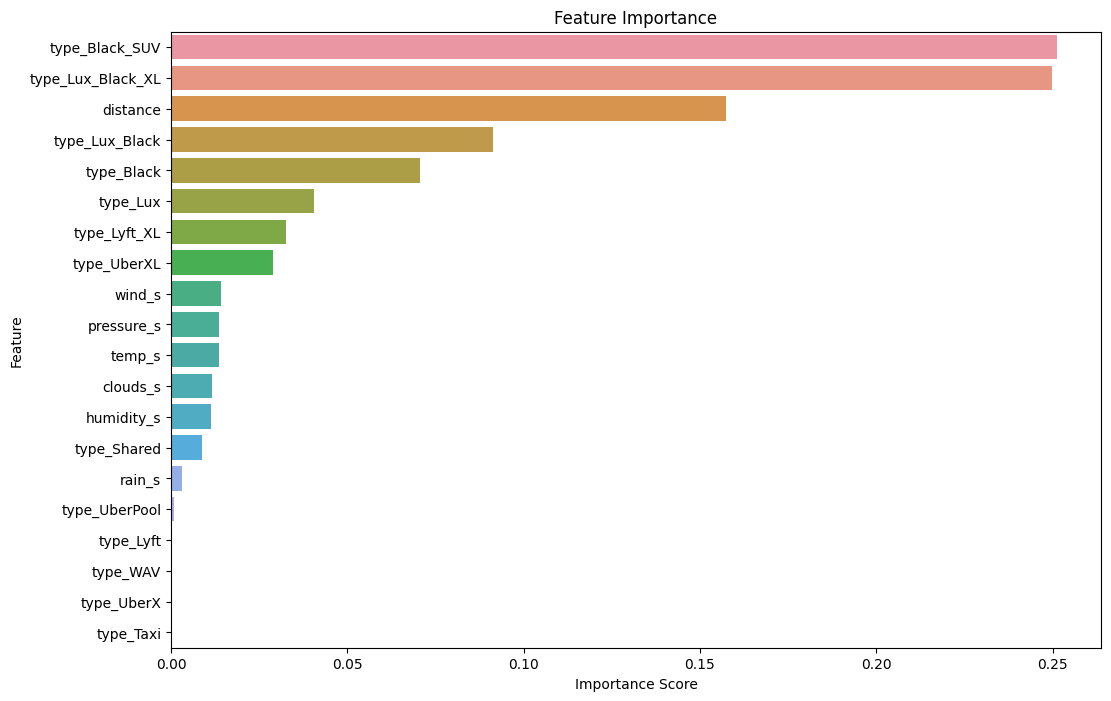

In [12]:
all_cols = weather_cols + type_cols + ['distance']
crdf = df_types.dropna(subset=['price'] + all_cols)

X = crdf[all_cols].to_numpy()
y = crdf.price.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Creating Random Forest Model...")
rf_model = RandomForestRegressor(n_estimators=N_EST, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Model Created!")

print("Creating Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression Model Created!")

feature_importances = rf_model.feature_importances_
features = all_cols

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

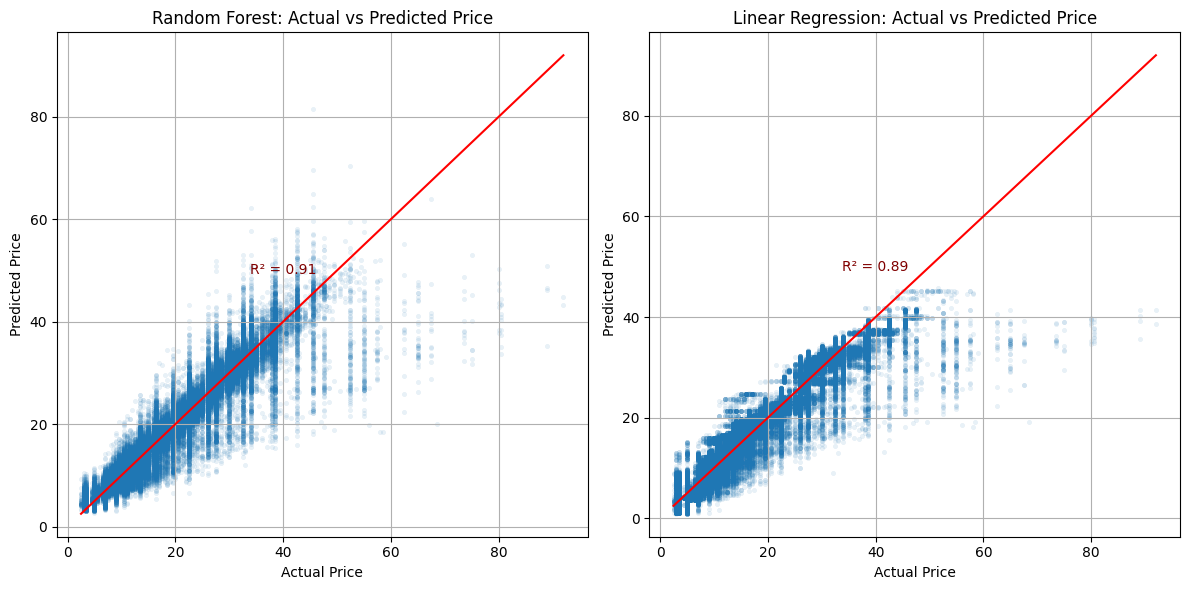

In [13]:
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_rf, alpha=0.1, s=10, edgecolor=None)
axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
axes[0].text(40, 50, f"R² = {r2_score(y_test, rf_model.predict(X_test)):.2f}", fontsize=10, color="maroon", ha='center', va='center')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Random Forest: Actual vs Predicted Price')
axes[0].grid(True)

sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_lr, alpha=0.1, s=10, edgecolor=None)
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='-')
axes[1].text(40, 50, f"R² = {r2_score(y_test, lr_model.predict(X_test)):.2f}", fontsize=10, color="maroon", ha='center', va='center')
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('Linear Regression: Actual vs Predicted Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Part 5: Temporal Trends

In [14]:
df_combined['time'] = pd.to_datetime(df_combined['time_stamp'], unit='ms')
df_combined['time_of_day'] = pd.cut(pd.to_datetime(df_combined['time_stamp'], unit='ms').dt.hour, bins=[-1, 5, 9, 15, 19, 24], labels=['N', 'M', 'N', 'E', 'N'], ordered = False)
df_combined['day_of_week'] = pd.to_datetime(df_combined['time_stamp'], unit='ms').dt.weekday

morning_df = df_combined[df_combined['time_of_day'] == 'M']
evening_df = df_combined[df_combined['time_of_day'] == 'E']

weekday_df = df_combined[df_combined['day_of_week'] < 5]
weekend_df = df_combined[df_combined['day_of_week'] >= 5]

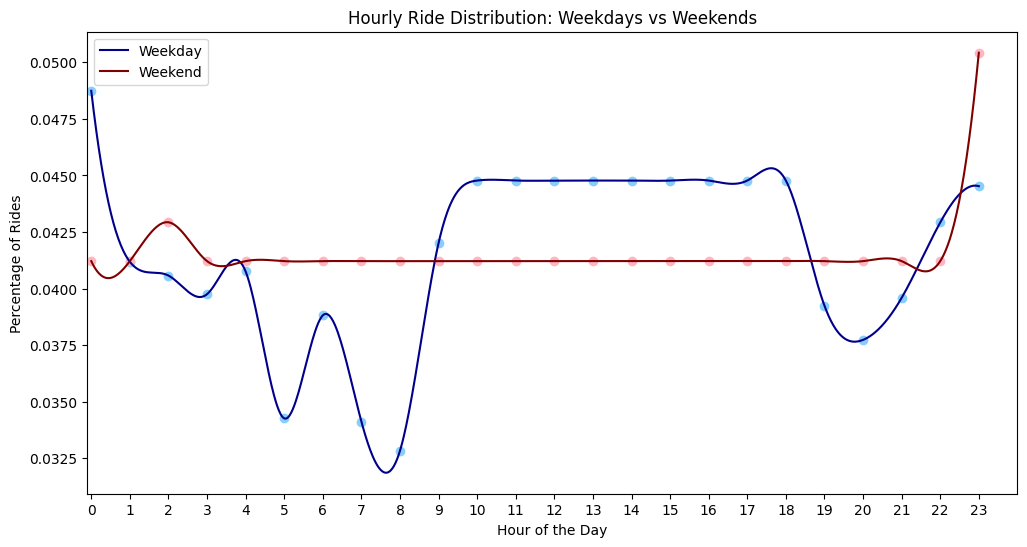

In [15]:
weekday_hourly_counts = weekday_df.time.dt.hour.value_counts(normalize=True).sort_index()
weekend_hourly_counts = weekend_df.time.dt.hour.value_counts(normalize=True).sort_index()

x_weekday = weekday_hourly_counts.index
y_weekday = weekday_hourly_counts.values

x_weekend = weekend_hourly_counts.index
y_weekend = weekend_hourly_counts.values

x_smooth = np.linspace(0, 23, 1080)

f_weekday = interp1d(x_weekday, y_weekday, kind='cubic')
y_smooth_weekday = f_weekday(x_smooth)

f_weekend = interp1d(x_weekend, y_weekend, kind='cubic')
y_smooth_weekend = f_weekend(x_smooth)

plt.figure(figsize=(12, 6))

sns.lineplot(x=x_smooth, y=y_smooth_weekday, label='Weekday', color='darkblue')
sns.lineplot(x=x_smooth, y=y_smooth_weekend, label='Weekend', color='maroon')

plt.scatter(x_weekday, y_weekday, color='lightskyblue', marker='o')
plt.scatter(x_weekend, y_weekend, color='lightpink', marker='o')
plt.xticks(ticks=np.arange(0, 24, 1))

plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Rides')
plt.title('Hourly Ride Distribution: Weekdays vs Weekends')
plt.xlim(-0.1, 24)
plt.legend()

plt.show()

In [16]:
trips_full = df_combined[['source','destination']].value_counts().sort_index().index
starts_full = df_combined['source'].value_counts().sort_index().index

trips = df_combined[['loc_s','loc_d']].value_counts().sort_index().index
starts = df_combined['loc_s'].value_counts().sort_index().index

In [17]:
all_trip_counts = df_combined[['loc_s','loc_d']].value_counts().sort_index().to_numpy()
morning_trip_counts = morning_df[['loc_s','loc_d']].value_counts().sort_index().to_numpy()
evening_trip_counts = evening_df[['loc_s','loc_d']].value_counts().sort_index().to_numpy()

all_start_count = df_combined['loc_s'].value_counts().sort_index()
morning_start_count = morning_df['loc_s'].value_counts().sort_index()
evening_start_count = evening_df['loc_s'].value_counts().sort_index()

all_trip_freqs = all_trip_counts / sum(all_trip_counts)
morning_trip_freqs = morning_trip_counts / sum(morning_trip_counts)
evening_trip_freqs = evening_trip_counts / sum(evening_trip_counts)

all_start_freqs = all_start_count / sum(all_start_count)
morning_start_freqs = morning_start_count / sum(morning_start_count)
evening_start_freqs = evening_start_count / sum(evening_start_count)

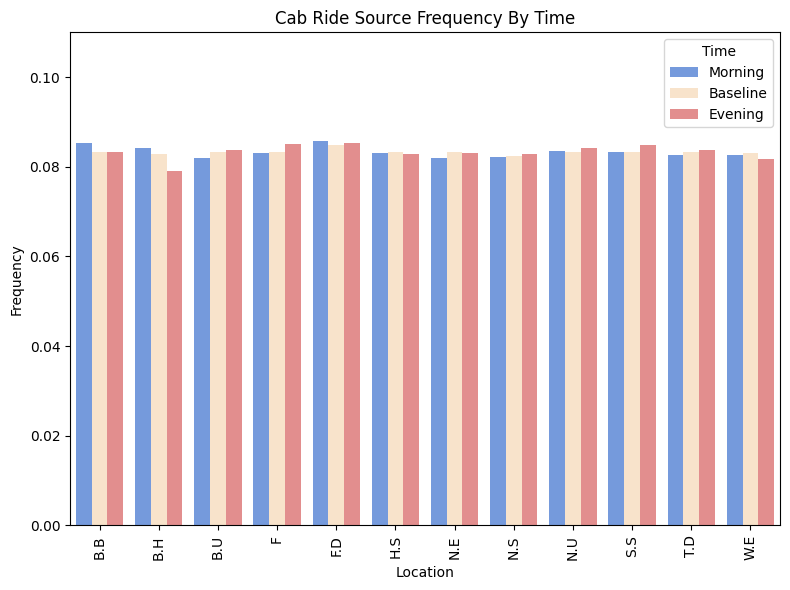

In [18]:
df = pd.DataFrame([morning_start_freqs, all_start_freqs, evening_start_freqs]).T
df.columns = ["base_md", "base", "base_ed"]

df_melted = df[["base_md", "base", "base_ed"]].reset_index().melt(id_vars='index', var_name='time', value_name='frequency')

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='index', y='frequency', hue='time', data=df_melted, palette=["cornflowerblue", "bisque", "lightcoral"])

plt.xticks(rotation=90)
plt.ylim(0, 0.11)
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.title('Cab Ride Source Frequency By Time')

handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles, ['Morning', 'Baseline', 'Evening'], title='Time', loc='upper right')
plt.tight_layout()
plt.show()

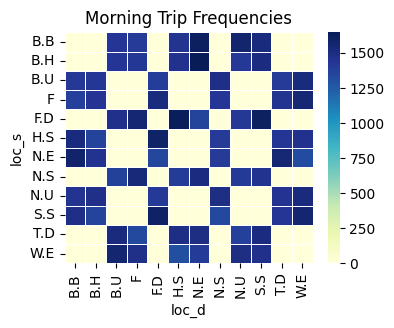

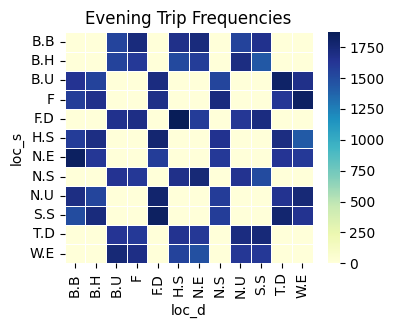

In [19]:
def plot_heatmap(data, title):
    df = pd.DataFrame(data[['loc_s','loc_d']].value_counts().sort_index())
    df.columns = ['counts']
    pivot_table = df.pivot_table(index='loc_s', columns='loc_d', values='counts', fill_value=0)
    plt.figure(figsize=(4, 3))
    sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=.5)
    plt.title(title)
    plt.show()

plot_heatmap(morning_df, 'Morning Trip Frequencies')
plot_heatmap(evening_df, 'Evening Trip Frequencies')

In [20]:
def diff_heatmap(baseline, curline, labels, title=None):
    df = pd.DataFrame(pd.Series(curline-baseline, index=labels))
    df.columns = ['diffs']
    pivot_table = df.pivot_table(index='loc_s', columns='loc_d', values='diffs', fill_value=0)
    plt.figure(figsize=(6, 5))
    sns.heatmap(pivot_table, cmap='RdYlGn', linewidths=.5)
    plt.title(title)
    plt.show()

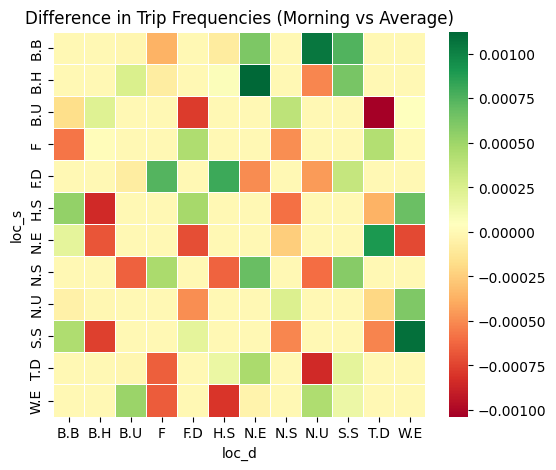

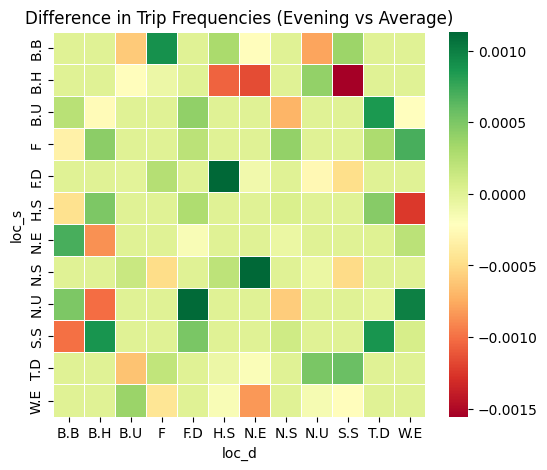

In [21]:
diff_heatmap(all_trip_freqs, morning_trip_freqs, trips, 'Difference in Trip Frequencies (Morning vs Average)')
diff_heatmap(all_trip_freqs, evening_trip_freqs, trips, 'Difference in Trip Frequencies (Evening vs Average)')

In [22]:
def rec_driver(baseline, curline, labels, k=None):
    if k == None:
        k = len(labels)//6
    t_diffs = curline - baseline
    fallers = [(labels[i], t_diffs[i]/baseline[i]) for i in (t_diffs).argsort()[:k]]
    risers = [(labels[i], t_diffs[i]/baseline[i]) for i in (t_diffs).argsort()[-k:][::-1]]

    if type(labels[0]) == str:
        ret_message = [f"{'Avoid' if i[1]<0 else 'Go to'} {i[0]} as trips from {i[0]} {'drop' if i[1]<0 else 'rise'} by {abs(100*i[1]):.2f}%" for i in fallers+risers]
    else:
        ret_message = [f"{'Avoid' if i[1]<0 else 'Go to'} Route '{i[0][0]} - {i[0][1]}' as demand {'drops' if i[1]<0 else 'rises'} by {abs(100*i[1]):.2f}%" for i in fallers+risers]
    return ret_message

In [23]:
#Rider Route Recommendations (morning)
rec_driver(all_trip_freqs, morning_trip_freqs, trips_full, 3)

["Avoid Route 'Boston University - Theatre District' as demand drops by 7.21%",
 "Avoid Route 'Haymarket Square - Beacon Hill' as demand drops by 6.14%",
 "Avoid Route 'Theatre District - Northeastern University' as demand drops by 6.08%",
 "Go to Route 'Beacon Hill - North End' as demand rises by 7.76%",
 "Go to Route 'South Station - West End' as demand rises by 7.86%",
 "Go to Route 'Back Bay - Northeastern University' as demand rises by 7.60%"]

In [24]:
#Rider Source Recommendations (evening)
rec_driver(all_start_freqs, evening_start_freqs, starts_full)

['Avoid Beacon Hill as trips from Beacon Hill drop by 4.44%',
 'Avoid West End as trips from West End drop by 1.70%',
 'Go to Fenway as trips from Fenway rise by 2.06%',
 'Go to South Station as trips from South Station rise by 1.73%']

### Part 6: Surge Prices vs Time of Day & Day of Week

In [25]:
def day_hour_rides_pivot(df, cols): 
    df = df.copy()[cols]
    df['day'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    df = df[['day', 'hour', 'surge_multiplier']].groupby(['day', 'hour']).agg('count')
    day_hour_rides_df = df.pivot_table(index='day', columns='hour', values='surge_multiplier', fill_value=0)
    return day_hour_rides_df

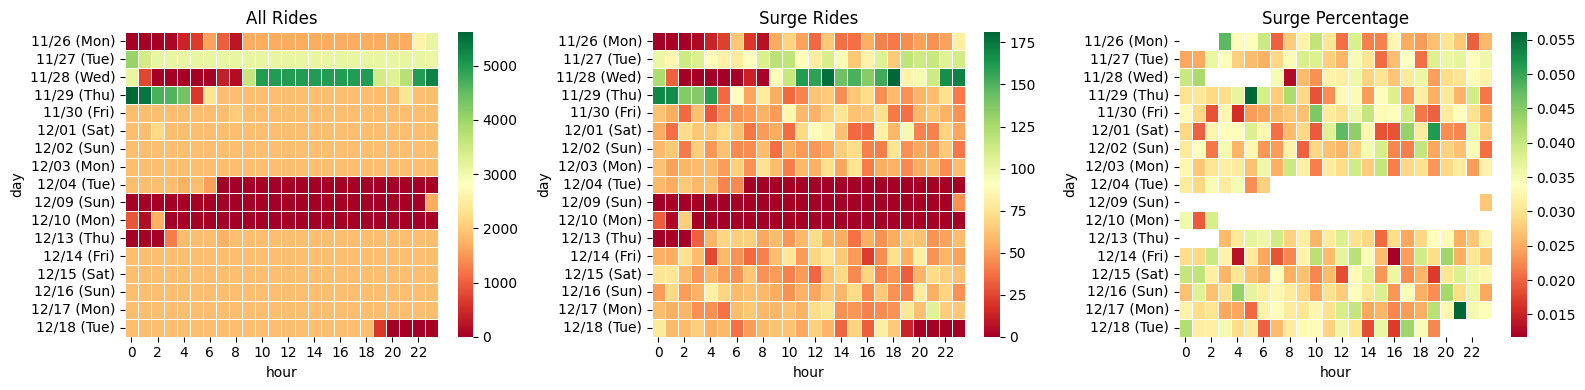

In [26]:
surge_rate_thres = 1
cols = ['price', 'loc_s', 'loc_d', 'surge_multiplier', 'time']

plot_df_all = day_hour_rides_pivot(df_combined, cols)
surge_df = df_combined[df_combined['surge_multiplier'] > surge_rate_thres]
plot_df_surge = day_hour_rides_pivot(surge_df, cols)

all_dh_df = day_hour_rides_pivot(df_combined, cols)
surge_dh_df = day_hour_rides_pivot(df_combined[df_combined['surge_multiplier'] > surge_rate_thres], cols)
surge_pct_df = surge_dh_df / all_dh_df

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

def format_yaxis(ax):
    labels = [item.get_text() for item in ax.get_yticklabels()]
    new_labels = []
    for label in labels:
        try:
            date = pd.to_datetime(label).strftime('%m/%d (%a)')
            new_labels.append(date)
        except:
            new_labels.append('')
    ax.set_yticklabels(new_labels, rotation=0)

sns.heatmap(plot_df_all, cmap='RdYlGn', linewidths=.5, ax=axes[0])
axes[0].set_title('All Rides')
format_yaxis(axes[0])
sns.heatmap(plot_df_surge, cmap='RdYlGn', linewidths=.5, ax=axes[1])
axes[1].set_title('Surge Rides')
format_yaxis(axes[1])
sns.heatmap(surge_pct_df, cmap='RdYlGn', linewidths=.5, ax=axes[2])
axes[2].set_title('Surge Percentage')
format_yaxis(axes[2])

plt.tight_layout()
plt.show()

### Part 7: Surge Prices vs Location

In [27]:
def weekday_loc_rides_pivot(df, frame='weekday'):
    df = df.copy()
    if frame == 'weekday':
        df[frame] = df['time'].dt.weekday
    elif frame == 'hour':
        df[frame] = df['time'].dt.hour
    df = df[[frame, 'source', 'destination']].groupby([frame, 'source']).agg('count')
    weekday_loc_rides_df = df.pivot_table(index=frame, columns='source', values='destination', fill_value=0)
    return weekday_loc_rides_df

def create_scatter_plots(df, title, axes, color, xax='Time'):
    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], color=color, marker='o', markersize=3, linestyle='-')
        ax.set_title(f'{col}')
        ax.set_xlabel(xax)
        ax.set_ylabel('Rides')
        ax.grid(True)
        
        max_value = df.index.max()
        ax.set_xlim(-0.2, max_value+0.2)

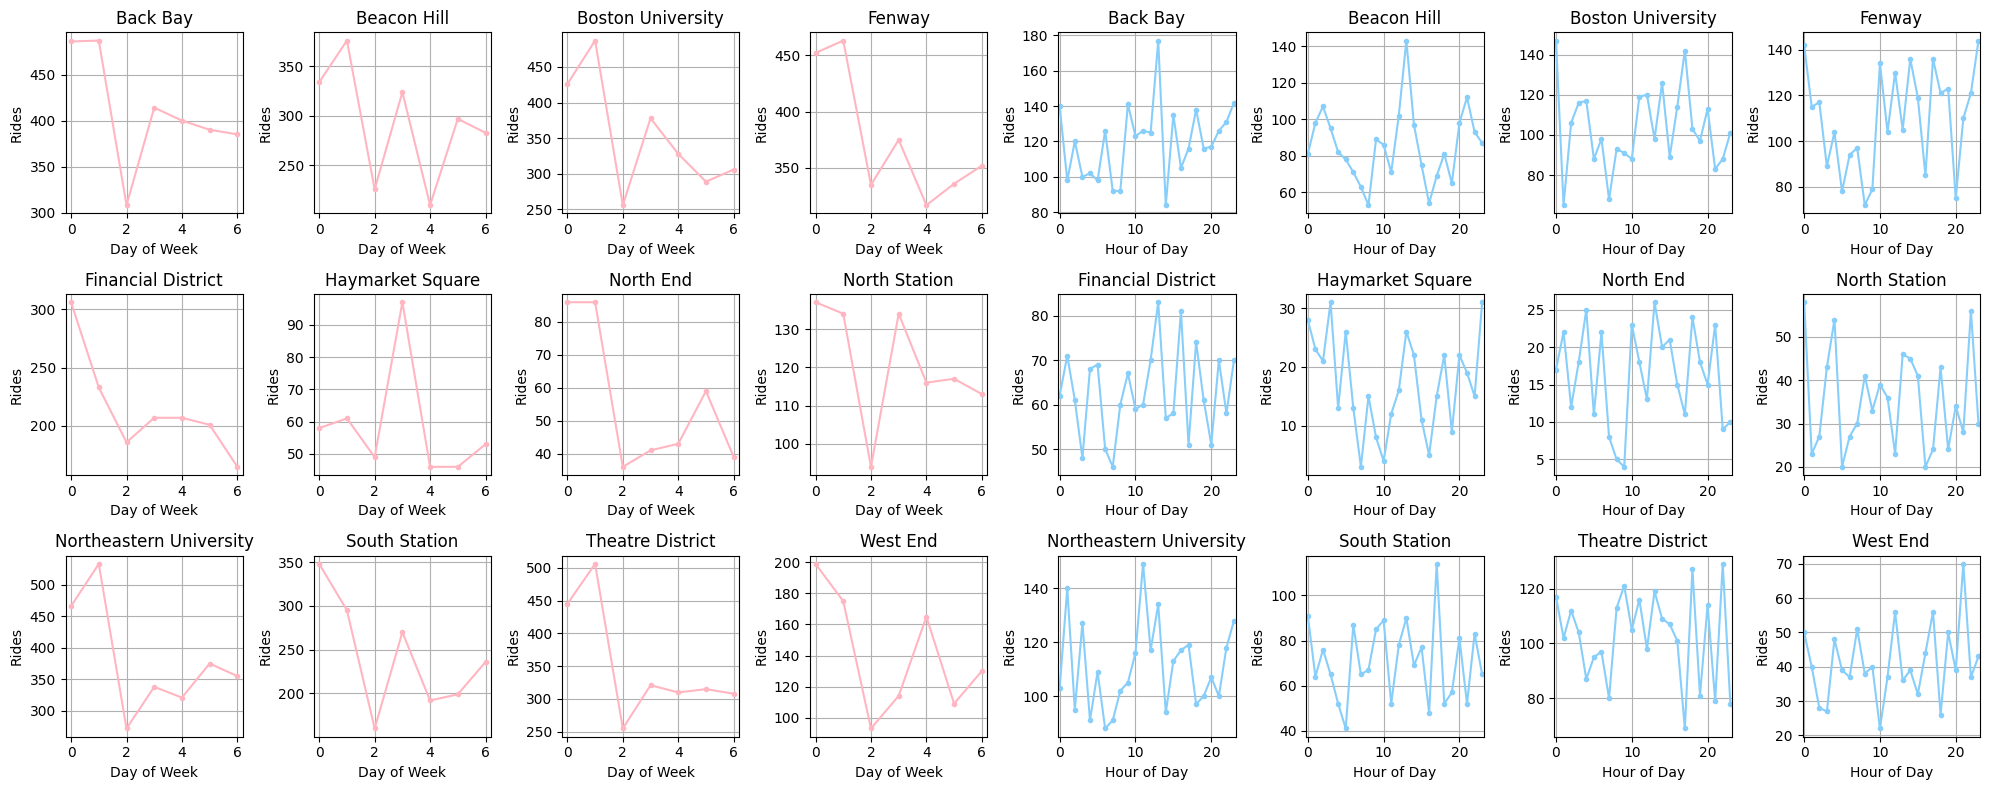

In [28]:
loc_weekday_df = weekday_loc_rides_pivot(df_combined[df_combined['surge_multiplier']>1])
loc_hour_df = weekday_loc_rides_pivot(df_combined[df_combined['surge_multiplier']>1], 'hour')

num_locations = len(loc_weekday_df.columns)
ncols = 4
nrows = (num_locations // ncols) + (1 if num_locations % ncols != 0 else 0)

fig = plt.figure(figsize=(20, 8))
gs = GridSpec(nrows, ncols * 2, figure=fig)

axes_weekday = [fig.add_subplot(gs[i // ncols, i % ncols]) for i in range(num_locations)]
create_scatter_plots(loc_weekday_df, 'Weekday Rides', axes_weekday, color='lightpink', xax='Day of Week')

axes_hourly = [fig.add_subplot(gs[i // ncols, ncols + (i % ncols)]) for i in range(num_locations)]
create_scatter_plots(loc_hour_df, 'Hourly Rides', axes_hourly, color='lightskyblue', xax='Hour of Day')

plt.tight_layout()
plt.show()

### Part 8: Surge Prices vs Weather Events

In [29]:
df_combined_w = df_combined[['surge_multiplier']+weather_cols].dropna()
interval = len(df_combined_w)/10
dec_tile_by_weather_var = {}
for var in weather_cols:
    var_list = []
    for i in range(10):
        s = int(interval*i)
        e = int(interval*(1+i))
        sample = df_combined_w.sort_values(var)[s:e+1:]['surge_multiplier']
        var_list.append(sample)
    f_statistic, p_value = stats.f_oneway(*var_list)
    print(f'F-statistic: {f_statistic}')
    print(f'P-value: {p_value}')          
    dec_tile_by_weather_var[var] = var_list

F-statistic: 1.9451336563585693
P-value: 0.04135616977537587
F-statistic: 3.242878816070321
P-value: 0.0006029742858123522
F-statistic: 1.8088241278176949
P-value: 0.06127308387747292
F-statistic: 6.174553722681011
P-value: 9.486743076662277e-09
F-statistic: 8.926858129084975
P-value: 1.3849329772666293e-13
F-statistic: 3.9235577687153738
P-value: 5.250053064102925e-05


In [30]:
weather_cols_sd = weather_cols+[col[:-1]+'d' for col in weather_cols]
df_combined_w = df_combined[['surge_multiplier']+weather_cols_sd].dropna()
y = df_combined_w['surge_multiplier']

X = df_combined_w[weather_cols_sd].copy()
for var in weather_cols_sd:
    X[f'{var}_squared'] = X[var] ** 2

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary().tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4321      0.797      0.542      0.588      -1.129       1.993
temp_s                -0.0039      0.002     -1.777      0.076      -0.008       0.000
clouds_s               0.0113      0.023      0.499      0.618      -0.033       0.056
pressure_s             0.6884      0.138      4.971      0.000       0.417       0.960
rain_s                -0.0241      0.027     -0.907      0.365      -0.076       0.028
humidity_s            -0.3454      0.081     -4.245      0.000      -0.505      -0.186
wind_s                -0.0172      0.002    -11.267      0.000      -0.020      -0.014
temp_d                 0.0039      0.002      1.782      0.075      -0.000       0.008
clouds_d              -0.0040      0.023     -0.176      0.860      -0.049       0.041
pressure_d            -0.6872      0.138   

In [31]:
p_values = model.pvalues
significance_level = 0.05
num_tests = len(p_values)
adjusted_significance_level = significance_level / num_tests
significant_vars_bonferroni = p_values[p_values < adjusted_significance_level].index.tolist()
print("Significant Variables with Bonferroni Correction:")
print(significant_vars_bonferroni) # pressure, humidity, wind

Significant Variables with Bonferroni Correction:
['pressure_s', 'humidity_s', 'wind_s', 'pressure_d', 'humidity_d', 'wind_d', 'pressure_s_squared', 'humidity_s_squared', 'wind_s_squared', 'pressure_d_squared', 'humidity_d_squared', 'wind_d_squared']


In [32]:
y = df_combined_w['surge_multiplier']

for var in weather_cols:
    X = sm.add_constant(df_combined_w[var])
    model = sm.OLS(y, X).fit()
    print(f'Regression analysis for {var}:')
    print(model.summary().tables[1])
    print()

y = df_combined_w['surge_multiplier']
X = df_combined_w[weather_cols]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(f'Regression analysis for Weather:')
print(model.summary().tables[1]) # pressure

Regression analysis for temp_s:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0148      0.001   1529.039      0.000       1.013       1.016
temp_s     -2.332e-05   1.67e-05     -1.397      0.162    -5.6e-05     9.4e-06

Regression analysis for clouds_s:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0143      0.000   3862.286      0.000       1.014       1.015
clouds_s      -0.0006      0.000     -1.714      0.087      -0.001    8.76e-05

Regression analysis for pressure_s:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0343      0.008    124.273      0.000       1.018       1.051
pressure_s -2.018e-05   8.2

In [33]:
def weekday_loc_rides_pivot(df, frame='weekday'):
    df = df.copy()
    if frame == 'weekday':
        df[frame] = df['time'].dt.weekday
    elif frame == 'hour':
        df[frame] = df['time'].dt.hour
    df = df[[frame, 'source', 'destination']].groupby([frame, 'source']).agg('count')
    weekday_loc_rides_df = df.pivot_table(index=frame, columns='source', values='destination', fill_value=0)
    return weekday_loc_rides_df

def create_scatter_plots(df, title, axes, color, xax='Time'):
    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], color=color, marker='o', markersize=3, linestyle='-')
        ax.set_title(f'{col}')
        ax.set_xlabel(xax)
        ax.set_ylabel('Rides')
        ax.grid(True)
        
        max_value = df.index.max()
        ax.set_xlim(-0.2, max_value+0.2)

### Part 9: Time Series Analysis

In [34]:
cols = ['price', 'loc_s', 'loc_d', 'surge_multiplier', 'time']
day_hour_count_df = day_hour_rides_pivot(df_combined, cols)

stacked_df = day_hour_count_df.stack()
filtered_df = stacked_df[stacked_df == 1872]
consistent_df = filtered_df.reset_index()
consistent_df.columns = ['day', 'hour', 'value']
consistent_df = consistent_df.drop(columns='value')
consistent_df.head()

,day,hour
0,2018-11-29,7
1,2018-11-29,8
2,2018-11-29,9
3,2018-11-29,10
4,2018-11-29,11


In [35]:
df_combined['time'] = pd.to_datetime(df_combined['time'])
df_combined['time_5min'] = df_combined['time'].dt.floor('5T')

df_combined['day'] = df_combined['time_5min'].dt.date
df_combined['hour'] = df_combined['time_5min'].dt.hour
df_combined['minute'] = df_combined['time_5min'].dt.minute

df_weekday = df_combined[df_combined['time_5min'].dt.weekday < 5]
df_weekend = df_combined[df_combined['time_5min'].dt.weekday > 4]

consistent_wkd = pd.merge(df_weekday, consistent_df, on=['day', 'hour'], how='inner')
consistent_wkn = pd.merge(df_weekend, consistent_df, on=['day', 'hour'], how='inner')
consistent_wkall = pd.merge(df_weekday, consistent_df, on=['day', 'hour'], how='inner')

cols = ['day', 'hour', 'minute', 'distance', 'cab_type', 'destination', 'source', 'loc_s', 'loc_d', 'name', 'surge_multiplier', 'surge_bool',
        'temp_s', 'clouds_s', 'pressure_s', 'rain_s', 'humidity_s', 'wind_s', 'temp_d', 'clouds_d', 'pressure_d', 'rain_d', 'humidity_d', 'wind_d']

consistent_wkd['surge_bool'] = consistent_wkd['surge_multiplier'] != 1
consistent_wkn['surge_bool'] = consistent_wkn['surge_multiplier'] != 1
consistent_wkall['surge_bool'] = consistent_wkall['surge_multiplier'] != 1

balanced_wkd = consistent_wkd[cols].sort_values(['day', 'hour'])
balanced_wkn = consistent_wkn[cols].sort_values(['day', 'hour'])
consistent_wkall[cols].sort_values(['day', 'hour'])

weekday_t_counts = balanced_wkd[['day', 'hour', 'minute', 'surge_bool']].groupby(['day', 'hour', 'minute']).agg('sum')
weekend_t_counts = balanced_wkn[['day', 'hour', 'minute', 'surge_bool']].groupby(['day', 'hour', 'minute']).agg('sum')
weekall_t_counts = consistent_wkall[['day', 'hour', 'minute', 'surge_bool']].groupby(['day', 'hour', 'minute']).agg('sum')

weekall_t_counts.head()

surge_bool
day        hour minute            
2018-11-29 7    0                8
                5                1
                10               2
                15               3
                20              12

In [36]:
h_m_weekday_avg = weekday_t_counts.groupby(['hour','minute']).agg(np.mean)['surge_bool'].round(2).to_dict()
h_m_weekend_avg = weekend_t_counts.groupby(['hour','minute']).agg(np.mean)['surge_bool'].round(2).to_dict()

full_index = pd.MultiIndex.from_product([
    pd.date_range(start='2018-11-29', end='2018-12-18', freq='D'),
    range(24),
    range(0, 60, 5)
], names=['day', 'hour', 'minute'])

full_data = weekall_t_counts.reindex(full_index)
full_data['is_weekend'] = full_data.index.get_level_values('day').weekday >= 5

def fill_na(row, weekday_avg, weekend_avg):
    hour_minute = (row.name[1], row.name[2])
    if pd.isna(row['surge_bool']):
        if row['is_weekend']:
            return weekend_avg.get(hour_minute, np.nan)
        else:
            return weekday_avg.get(hour_minute, np.nan)
    return row['surge_bool']

full_data['surge_bool'] = full_data.apply(
    fill_na, axis=1, args=(h_m_weekday_avg, h_m_weekend_avg)
)

full_data.drop(columns=['is_weekend'], inplace=True)
full_data.index = pd.to_datetime(full_data.index.get_level_values('day').astype(str) + ' ' +
                                 full_data.index.get_level_values('hour').astype(str) + ':' +
                                 full_data.index.get_level_values('minute').astype(str),
                                 format='%Y-%m-%d %H:%M')
full_data.head()

,surge_bool
2018-11-29 00:00:00,2.83
2018-11-29 00:05:00,3.50
2018-11-29 00:10:00,8.00
2018-11-29 00:15:00,5.83
2018-11-29 00:20:00,5.33


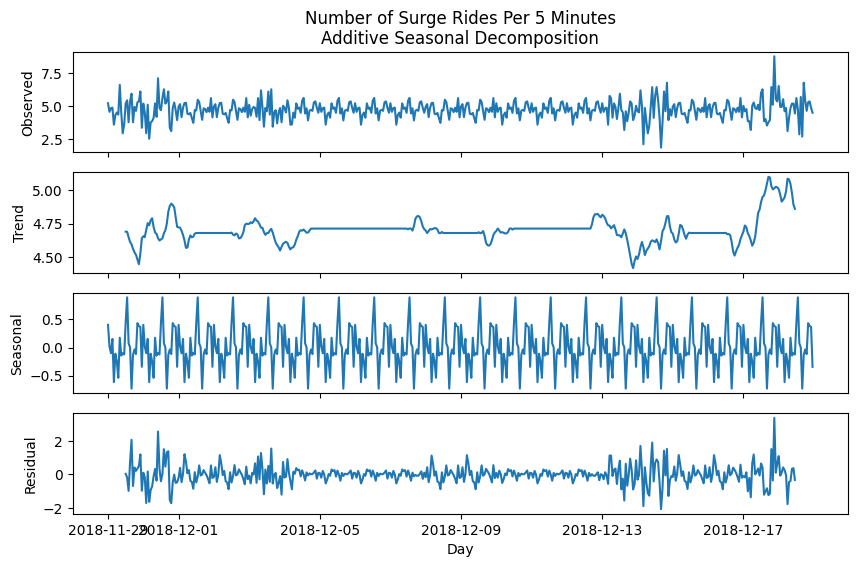

In [37]:
def seasonal_decompose_time_series(data, period, resample=5, model='additive'):
    resample_rule = f'{resample}T'
    data = data.resample(resample_rule).mean()
    decomposition = sm.tsa.seasonal_decompose(data, period=period, model=model)
    return decomposition

def plot_decomp(res, title):
    fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    axes[0].set_title("Additive Seasonal Decomposition")
    axes[0].plot(res.observed)
    axes[0].set_ylabel("Observed")

    axes[1].plot(res.trend)
    axes[1].set_ylabel("Trend")

    axes[2].plot(res.seasonal)
    axes[2].set_ylabel("Seasonal")

    axes[3].plot(res.resid)
    axes[3].set_ylabel("Residual")

    axes[3].set_xlabel("Day")
    fig.suptitle(title, x=0.513, y=0.95)
    plt.show()

resampler = 60
period = 1440//resampler # 12 (5 min) per hour * 24 hours
res = seasonal_decompose_time_series(full_data['surge_bool'], period=period, resample=resampler, model='additive')
plot_decomp(res, "Number of Surge Rides Per 5 Minutes")

In [39]:
def calc_wma(ser, wd_size, weights=1):

    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)

    wma = []
    for j in range(len(ser)):
        if j < wd_size:
            partial_weights = weights[-j-1:]
            partial_series = ser[:j+1]
            wms = 0
            for i in range(j+1):
                wms += partial_series[i] * partial_weights[i]
            wma.append(wms / sum(partial_weights))
        else:
            partial_series = ser[j-wd_size+1:j+1]
            wms = 0
            for i in range(wd_size):
                wms += partial_series[i] * weights[i]
            wma.append(wms / sum(weights))
    return np.array(wma)

def calc_time_ema(ser, lmbd=0.0):
    time_ema = []
    if lmbd == 0:
        for j in range(len(ser)):
            partial_series = ser[:j+1]
            time_ema.append(partial_series.mean())
        return np.array(time_ema)
    
    for j in range(len(ser)):
        partial_series = ser[:j+1]
        numerator = 0
        denominator = 0
        for i in range(len(partial_series)):
            t_diff = j - i
            weight = np.exp(-lmbd * t_diff)
            numerator += weight * partial_series[i]
            denominator += weight
        time_ema.append(numerator / denominator)
    return np.array(time_ema)

def apply_rolling_average(data, window_size, method='wma', weights=None, lmbd=0.5):
    if method == 'wma':
        if weights == None:
            weights = [i+1 for i in range(window_size)]
        data['rolling_surge_bool'] = calc_wma(data['surge_bool'].values, window_size, weights)
    elif method == 'ema':
        data['rolling_surge_bool'] = calc_time_ema(data['surge_bool'].values, lmbd)
    else:
        raise ValueError("Invalid method. Choose 'wma' or 'ema'.")
    
    return data

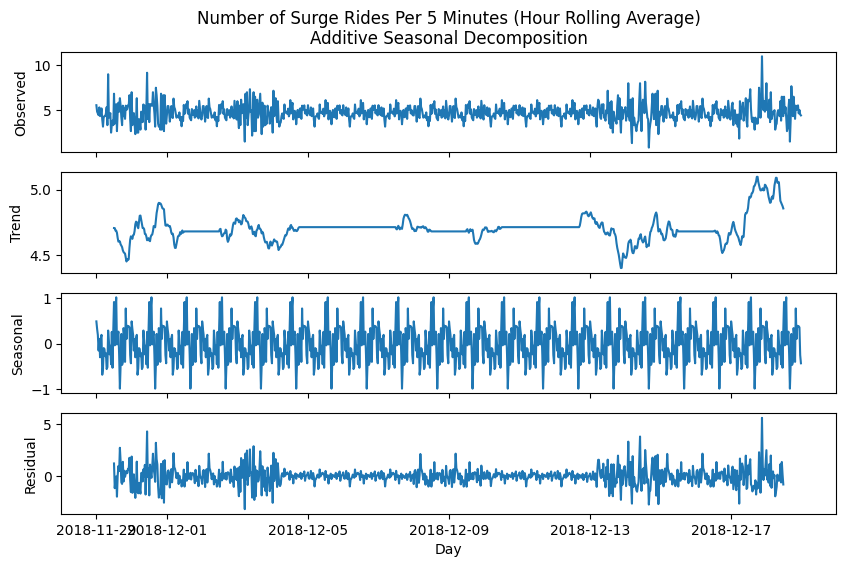

In [40]:
window_size = 12
method = 'wma'

full_data_rolling_avg = apply_rolling_average(full_data, window_size, method=method)

resampler = 30
period = 1440//resampler # 12 (5 min) per hour * 24 hours
res = seasonal_decompose_time_series(full_data['surge_bool'], period=period, resample=resampler, model='additive')
plot_decomp(res, "Number of Surge Rides Per 5 Minutes (Hour Rolling Average)")